In [1]:
% use A_div_Lq1 for fast computation
% plot distribution for heat source and heat flux
close all;
clear;

G_solution = 4215; % INPUT
heat_flux_source = 852*1000; % INPUT [W/m2]
T_inlet_uniform = 300; % [K]

## load data for 3d temperature profile

In [2]:
digit_thousands = floor(G_solution/1000);
digit_hundreds = floor((G_solution - digit_thousands*1000)/100);
digit_tens= floor((G_solution - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_solution - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname1      = ['./divisions_A_matrix/divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname1,'A_div_L_qbcs1');

% calculate 3d temperature profile
T_steady = A_div_L_qbcs1*heat_flux_source + T_inlet_uniform;

## number grid

In [3]:
e_channel = 0.5*1.95*10^-3; % [m] half height of flow channel (we use symmetry here: total channel height is 2 mm)
L_channel = 0.056; % [m] flow length
w_channel = 18*10^-3; % [m] width channel (just for information)
% T_inlet_uniform = T_K(1); % [K] uniform temperature at inlet
t_solid = 2.00*10^-3; % [m] solid thickness

t_liquid_boundary = (0.4875*10^-6)*(50); % [m] boundary layer thickness: (near-wall)*(# cells)
N_x_1 = 300+1; % INPUT total number of liquid grid points (including both ends) in x-direction
N_x_1_boundary = 50+1; % INPUT including liquid-solid interface
N_x_1_bulk = N_x_1 - N_x_1_boundary; % including bulk end, excluding boundary
N_z = 100+1; % INPUT number of grid points (including both ends: inlet and outlet) in z-direction
N_x_2 = 40+1; % INPUT for solid substrate (including both ends: interface and outer wall)
N_x_tot = N_x_1 + N_x_2 - 1;
N_y = 19; % INPUT number of grid points in width direction

% First point is under specified temperature, and the rest (N_z - 1) points will be under heat flux.
z_grid = linspace(0, L_channel, N_z); % [m] distance from inlet
z_grid_mm = z_grid*1000;
dz = L_channel/(N_z - 1); % equal grid size
y_grid = linspace(0, w_channel/2, N_y); % [m] distance from the symmetry plane
y_grid_mm = y_grid*1000;
dy = y_grid(2) - y_grid(1);
x_grid_liquid_boundary = linspace(e_channel-t_liquid_boundary, e_channel, N_x_1_boundary);

% hyperbolic tangent grid with stretching parameter
beta_stretch = 2.1; % INPUT, larger the steeper at the end. check smoothness of the cell size
% Create the one-sided hyperbolic-tangent spaced grid
xi = linspace(0, 1, N_x_1_bulk + 1);
grid_hyperbolic = x_grid_liquid_boundary(1) - (1-tanh(beta_stretch*xi)/tanh(beta_stretch))*(e_channel - t_liquid_boundary); % including overlap
x_grid_liquid_bulk = grid_hyperbolic(1:end-1); % excluding interface, sees non-uniform grid

x_grid_liquid = [x_grid_liquid_bulk, x_grid_liquid_boundary]; % [m] distance from bulk (row vector)
dx = x_grid_liquid(end)-x_grid_liquid(end-1); % near-wall cell size
x_grid_solid = linspace(e_channel+dx, e_channel+t_solid, N_x_2-1); % excluding interface
dx_solid = (x_grid_solid(end)-x_grid_solid(1))/(N_x_2 - 2);

x_grid_total = [x_grid_liquid, x_grid_solid]; % entire grid

## physical properties

water properties from XSteam


In [4]:
P_in = 1.00; % [bar] INPUT 'Pressure_inlet' from CDTS (12.00; 12.07; 12.04);
Tb_in = 26.2; % [degC]
k_cond = XSteam('tc_pT', P_in, Tb_in); % [W/m/K] thermal conductivity
% sapphire properties
k_cond_s = 35; % [W/m/K]
% interface properties
k_cond_int = 2*k_cond_s*k_cond/(k_cond_s+k_cond); % at interface
k_cond_lint = 4*k_cond_s*k_cond/(3*k_cond_s+1*k_cond); % between liquid and interface
k_cond_sint = 4*k_cond_s*k_cond/(1*k_cond_s+3*k_cond); % between solid and interface

## 3d temperature

In [5]:
T_3d = reshape(T_steady, [N_z, N_x_tot, N_y]);

## 2d temperature: symmetry plane (y=0), interface plane

In [6]:
T_2d_symmetry = T_3d(:,:,1);
index_plane2 = 10; % INPUT
T_2d_plane2 = T_3d(:,:,index_plane2);

T_2d_interface = reshape(T_3d(:,N_x_1,:),[N_z, N_y]); % solid-liquid interface
T_2d_interface_above = reshape(T_3d(:,N_x_1-1,:),[N_z, N_y]); % liquid right above interface
T_2d_interface_below = reshape(T_3d(:,N_x_1+1,:),[N_z, N_y]); % solid right below interface

## 2d heat flux to water at interface plane

In [7]:
q_solid_2d = zeros(N_z, N_y);
q_liquid_2d = zeros(N_z, N_y);

q_solid_2d = -k_cond_sint*(T_2d_interface_below - T_2d_interface)/dx;
q_liquid_2d = -k_cond_lint*(T_2d_interface - T_2d_interface_above)/dx;
q_sum_2d = q_solid_2d - q_liquid_2d;

## centerline temperature and heat flux to water

In [8]:
T_wall_1 = zeros(N_z,1);
q_solid_1 = zeros(N_z,1);
q_liquid_1 = zeros(N_z,1);

T_wall_1 = T_2d_symmetry(:,N_x_1);
q_solid_1 = -k_cond_sint*(T_2d_symmetry(:,N_x_1+1)-T_2d_symmetry(:,N_x_1))/dx; % T_s - T_int
q_liquid_1 = -k_cond_lint*(T_2d_symmetry(:,N_x_1)-T_2d_symmetry(:,N_x_1-1))/dx; % T_int - T_l
q_sum = q_solid_1 - q_liquid_1; % compare against heat source

T_wall_2 = zeros(N_z,1);
q_liquid_2 = zeros(N_z,1);
T_wall_2 = T_2d_plane2(:,N_x_1);
q_liquid_2 = -k_cond_lint*(T_2d_plane2(:,N_x_1)-T_2d_plane2(:,N_x_1-1))/dx; % T_int - T_l

## 2d distribution


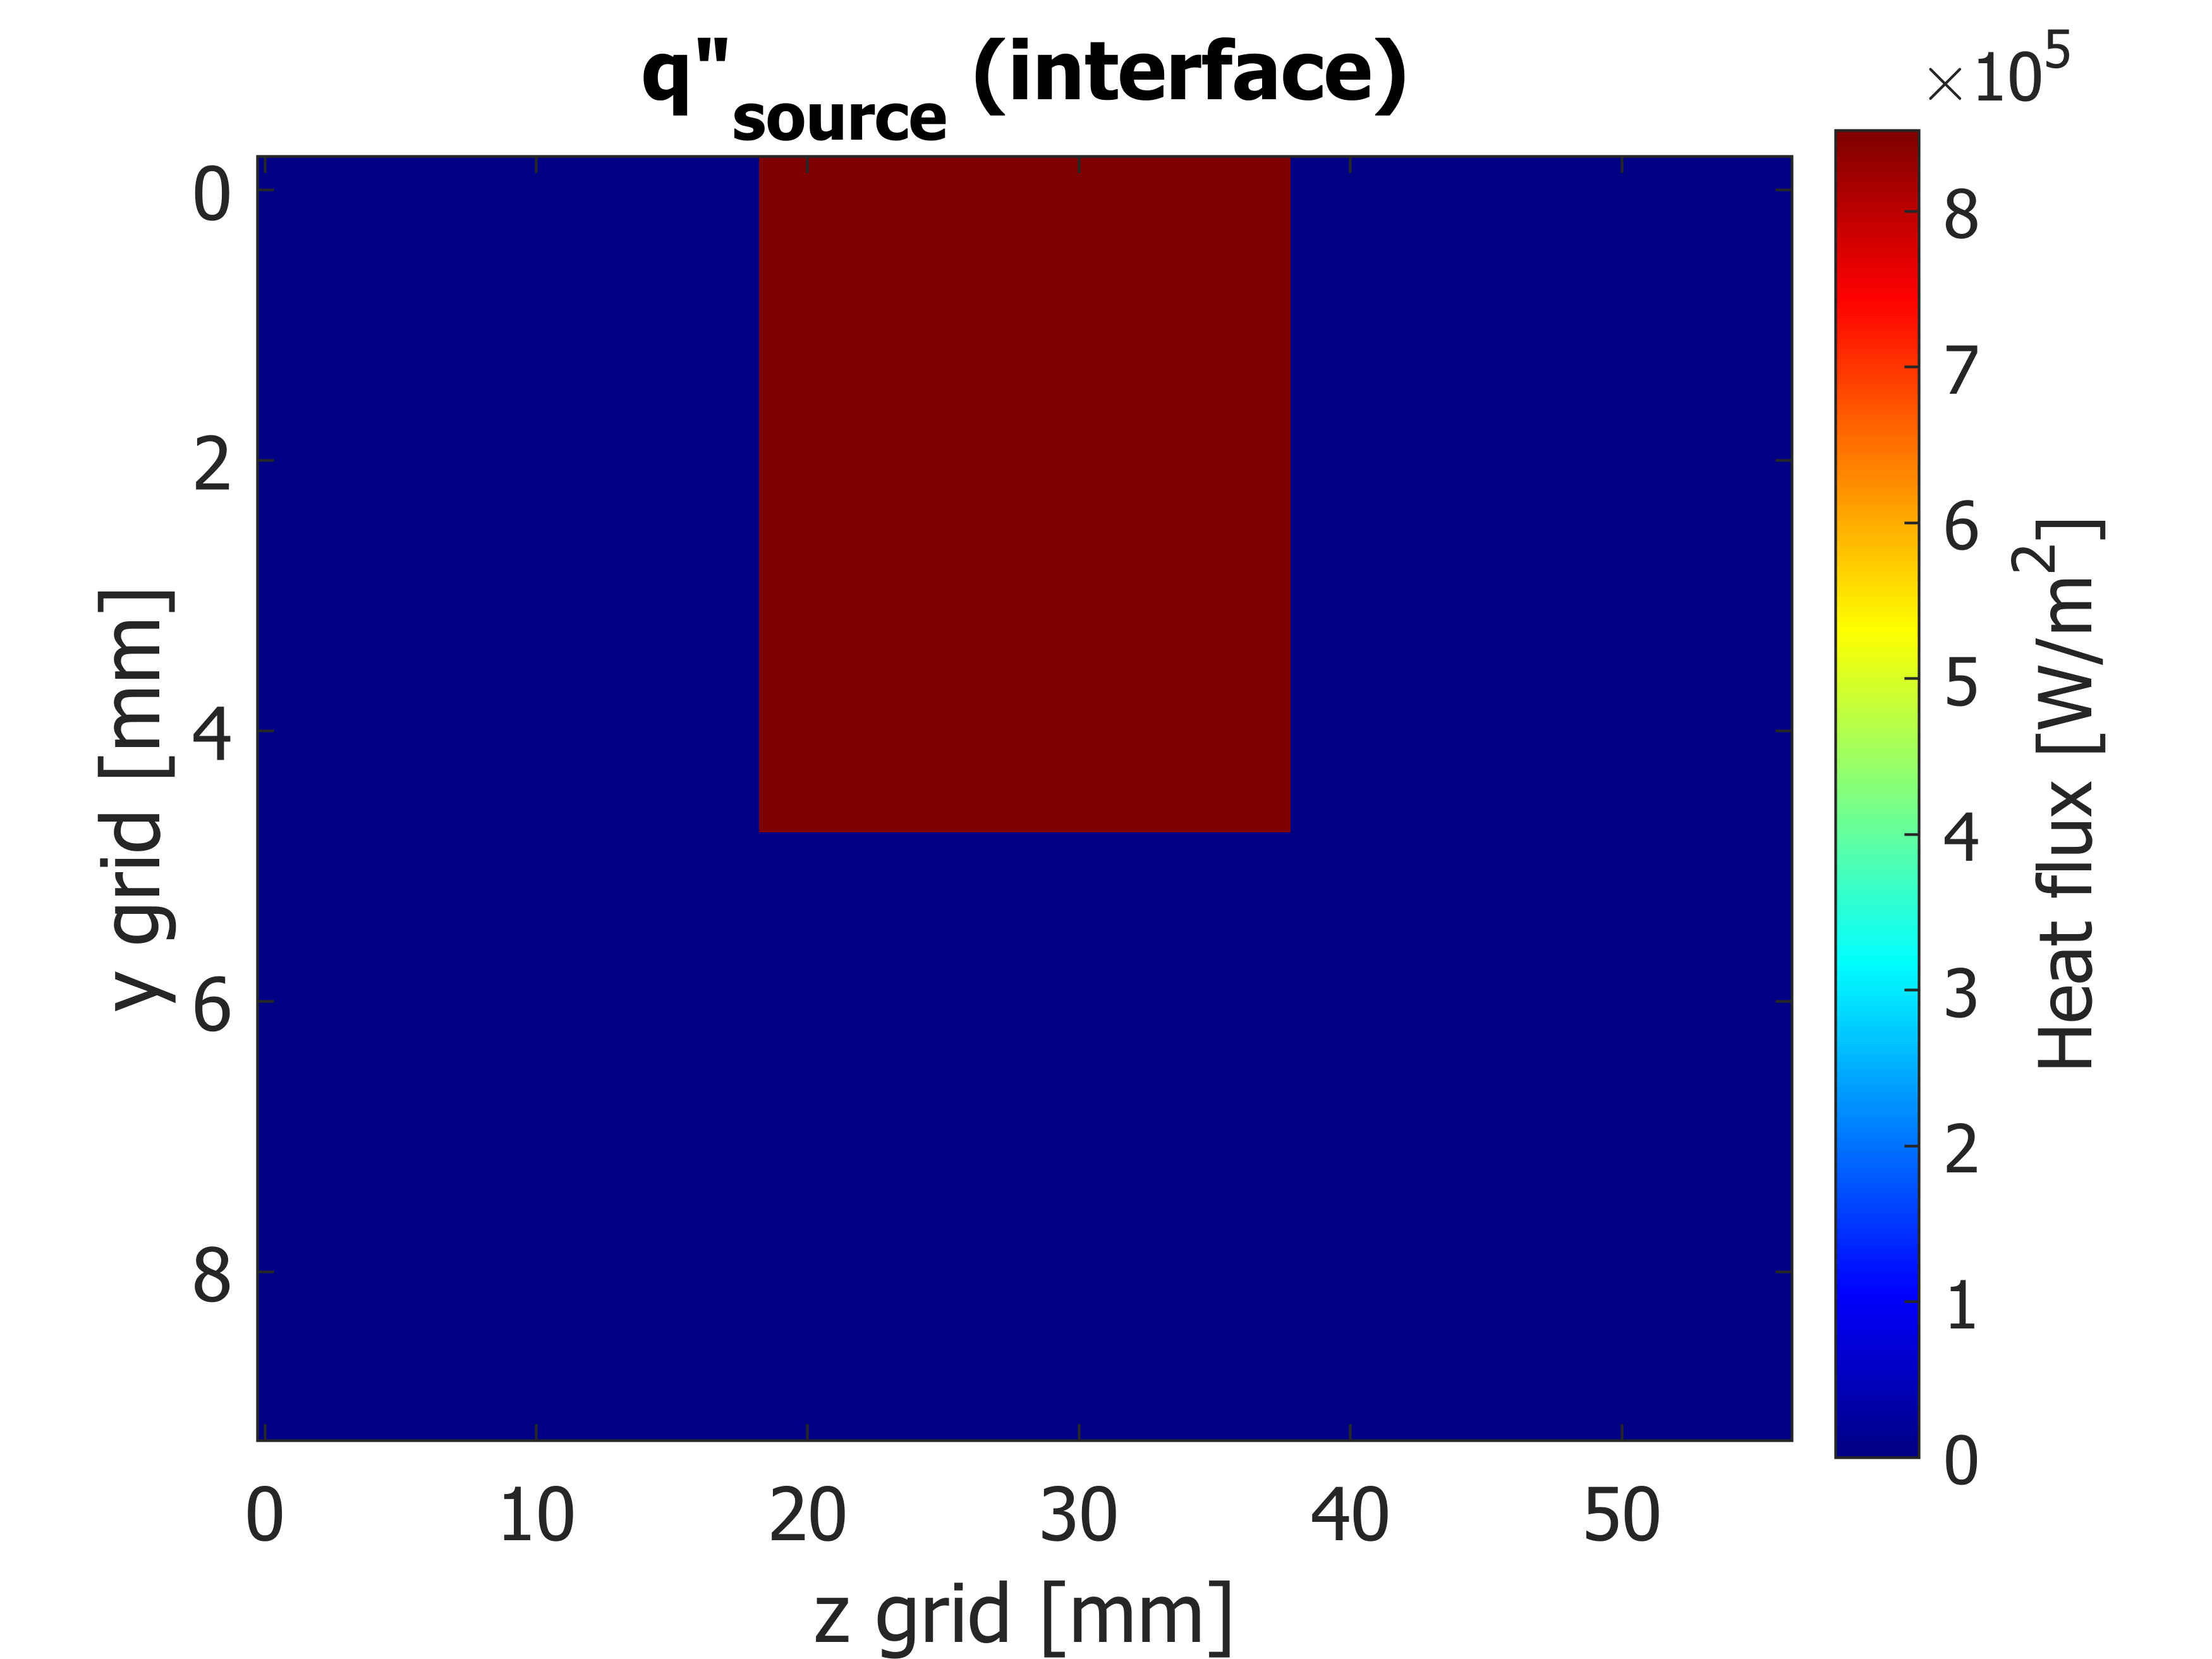

In [9]:
fontsize = 14;
figure;
set(gcf, 'WindowState', 'maximized');
% subplot(2,2,1)
imagesc(z_grid_mm, y_grid_mm, q_sum_2d');
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('q"_{source} (interface)')
c = colorbar;
ylabel(c, 'Heat flux [W/m^2]','FontSize',fontsize,'fontname','times')
caxis([0 heat_flux_source])
set(gca,'FontSize',fontsize,'fontname','times')
colormap('jet')


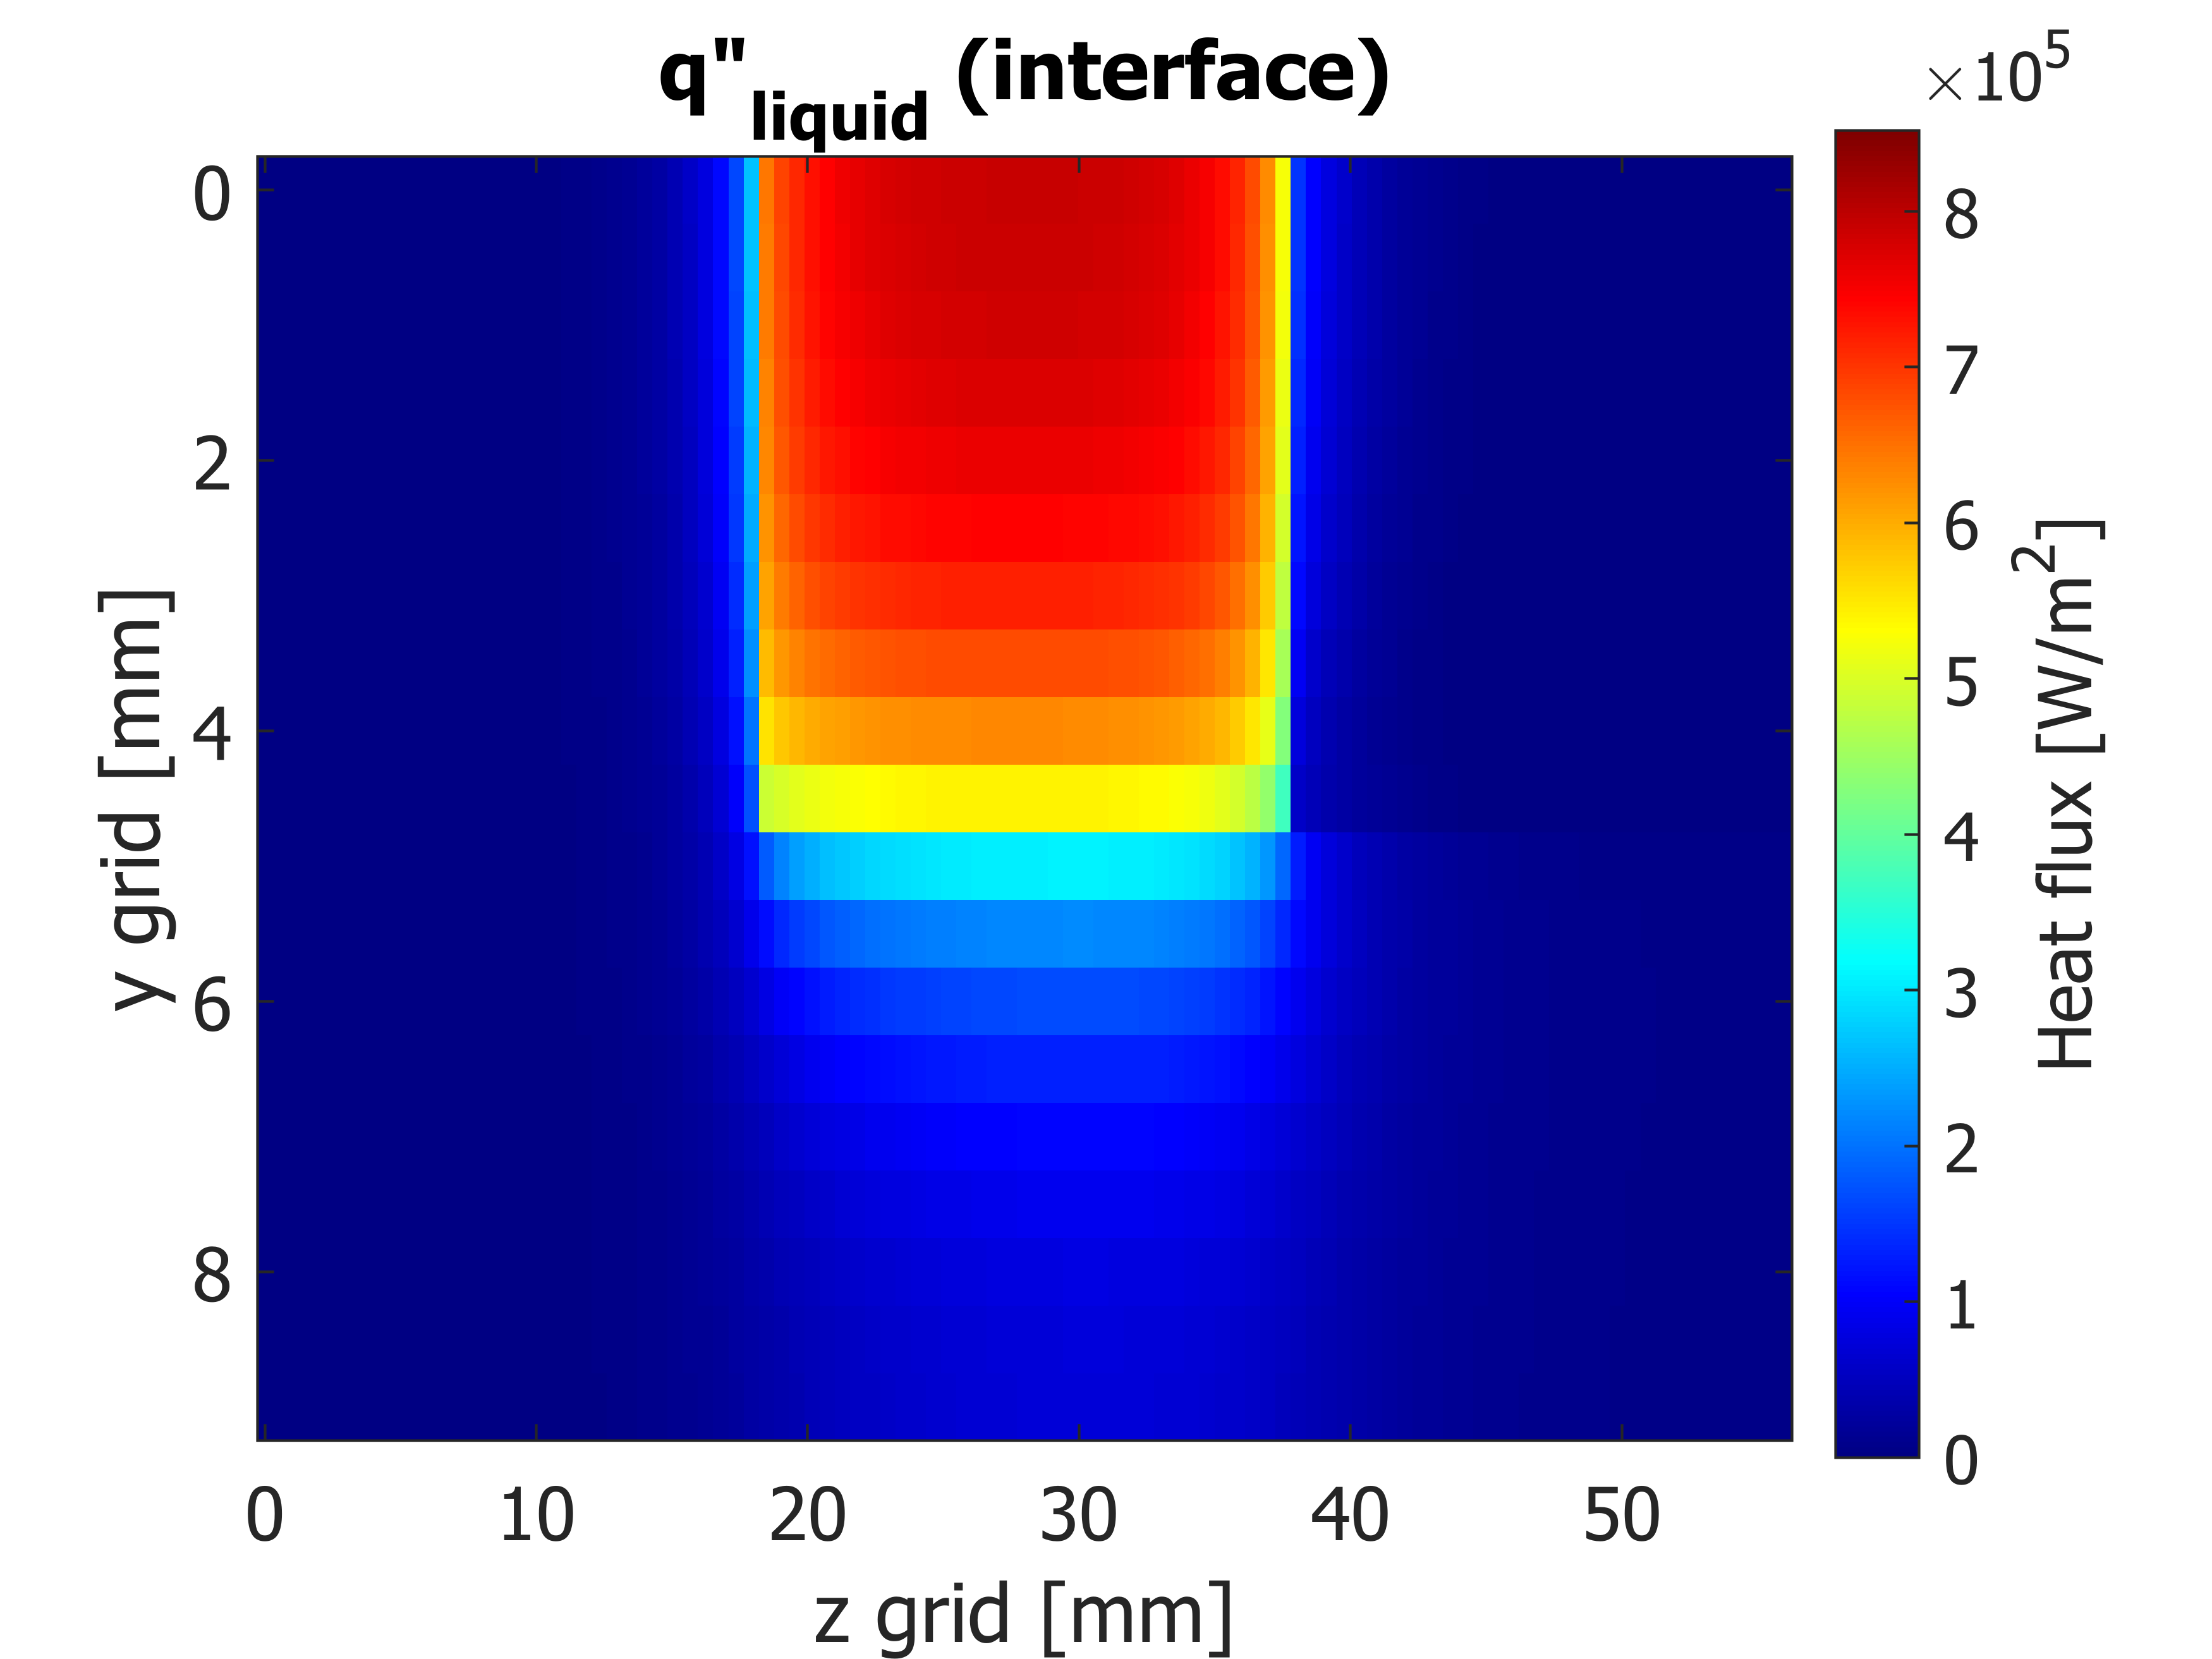

In [10]:

figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm, y_grid_mm, -q_liquid_2d');
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('q"_{liquid} (interface)')
c = colorbar;
ylabel(c, 'Heat flux [W/m^2]','FontSize',fontsize,'fontname','times')
caxis([0 heat_flux_source])
set(gca,'FontSize',fontsize,'fontname','times')
colormap('jet')


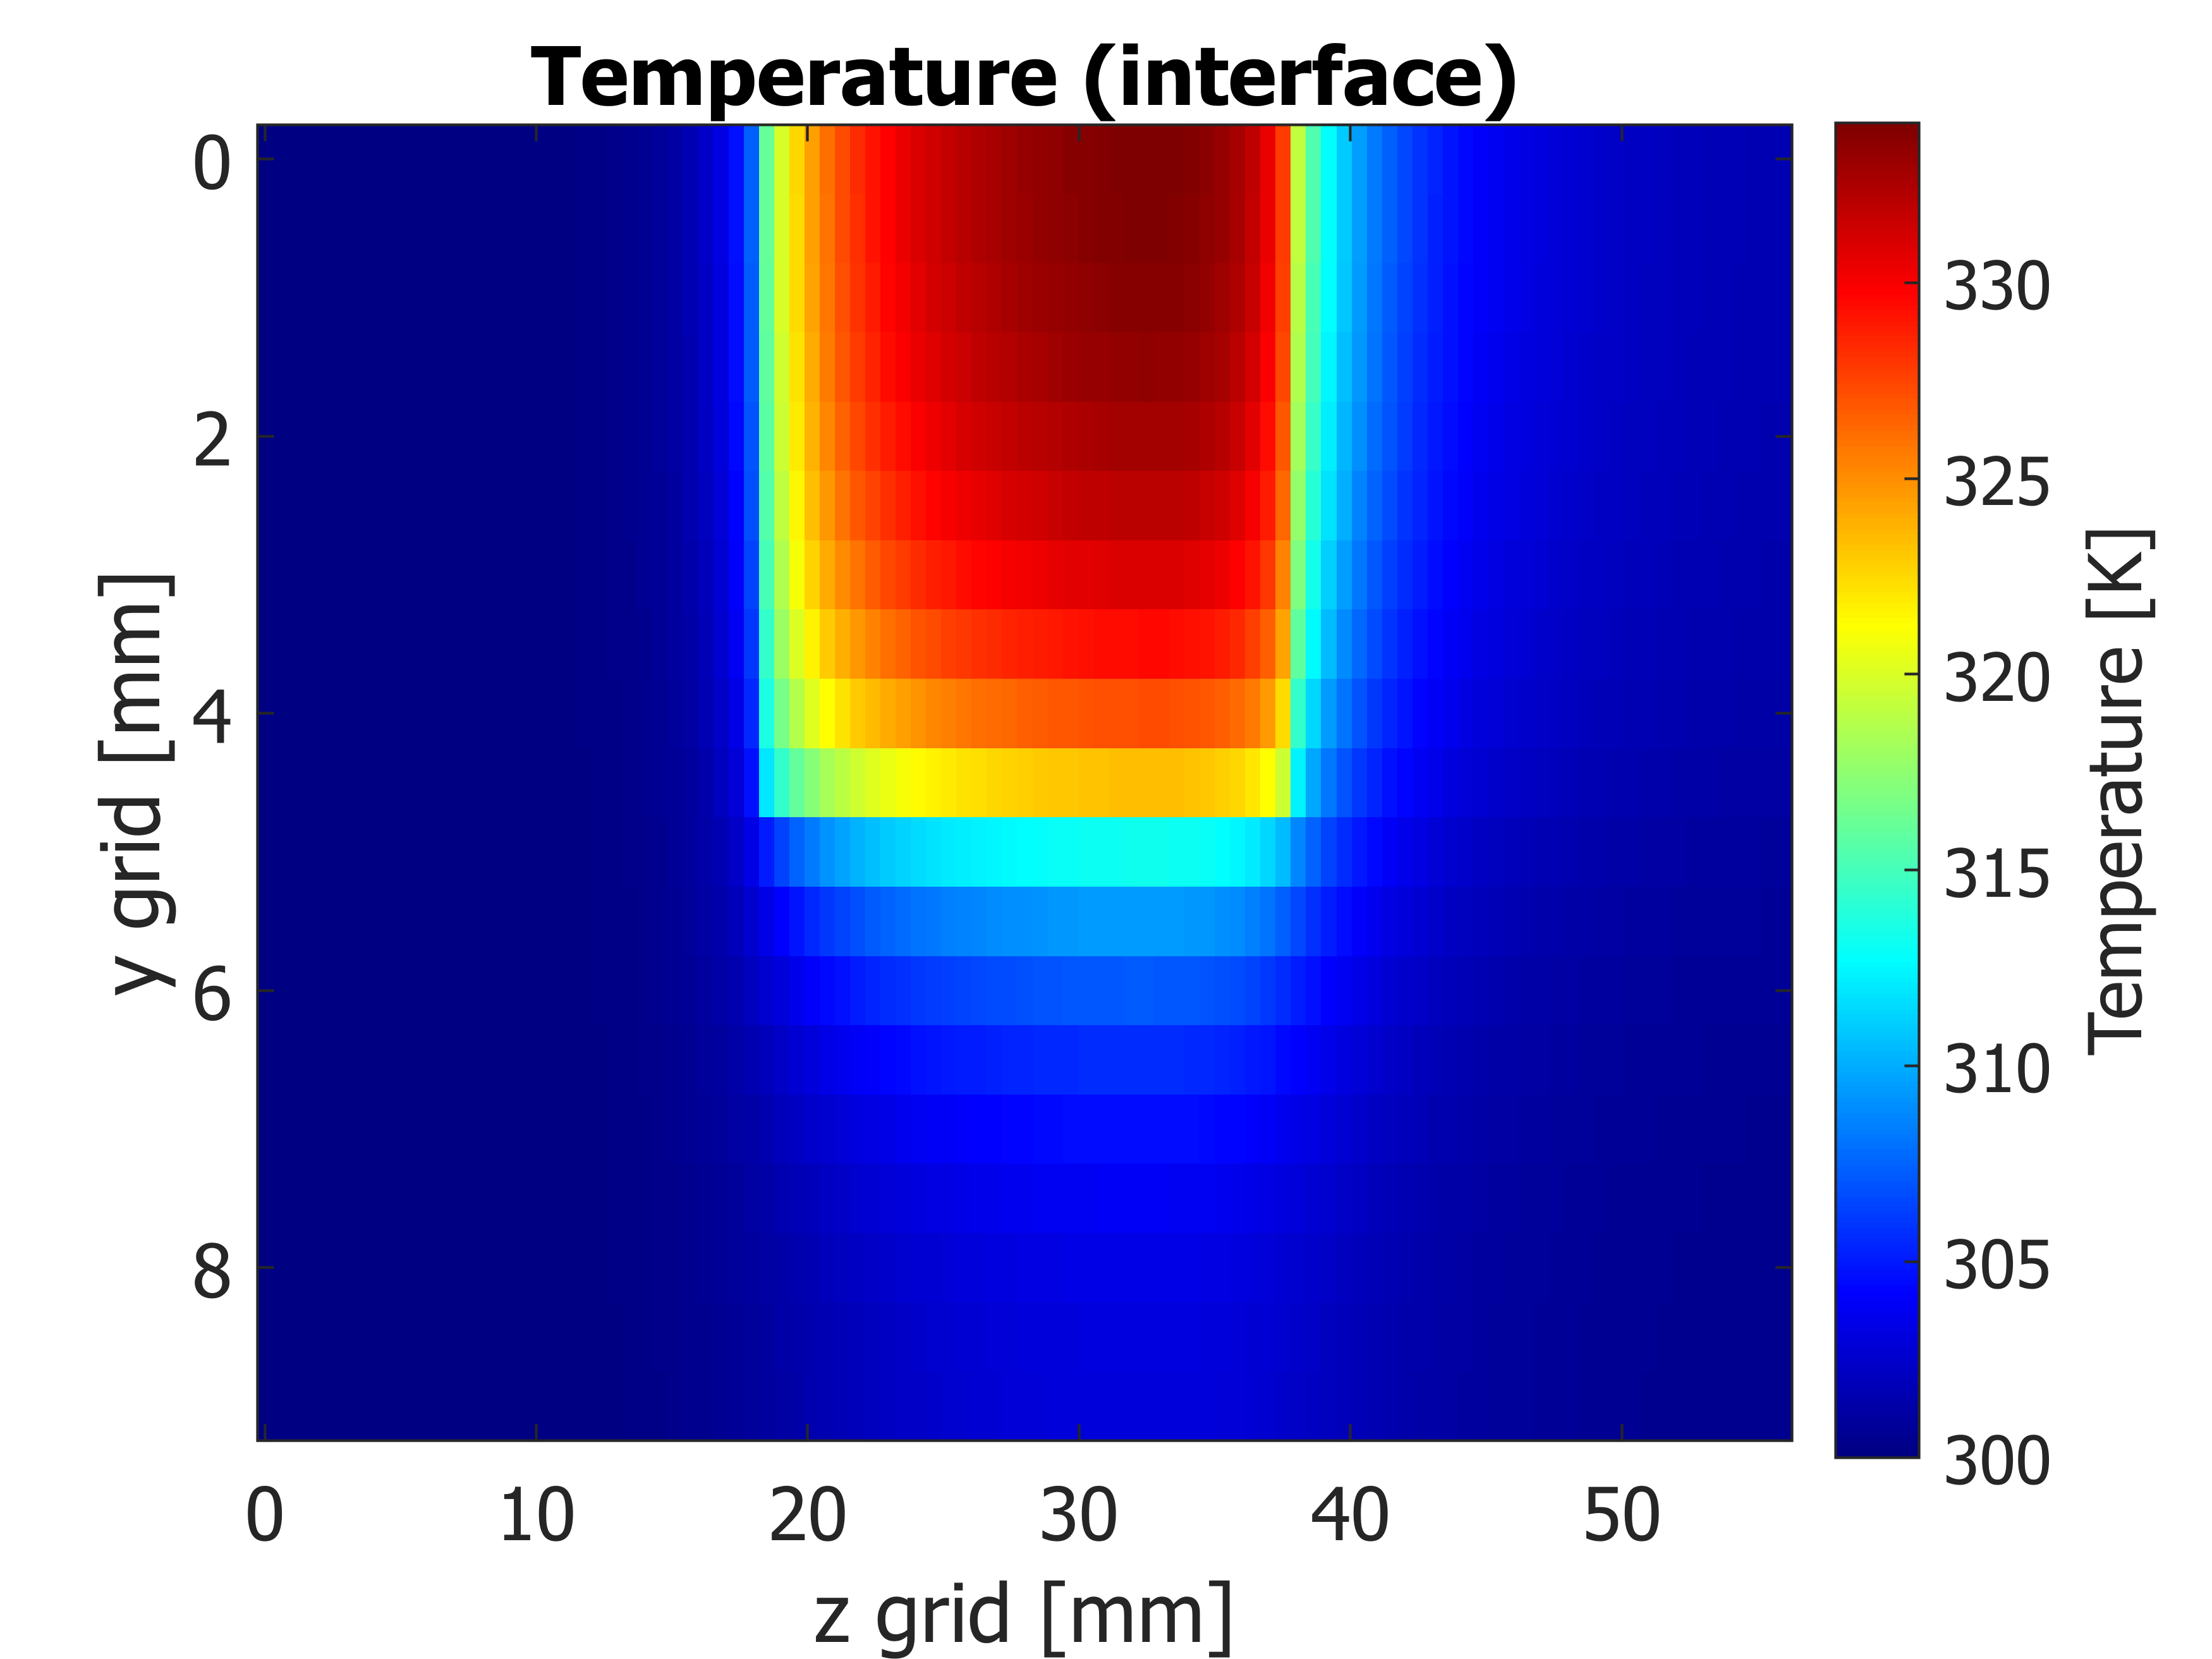

In [11]:

figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm, y_grid_mm, T_2d_interface');
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('Temperature (interface)')
c = colorbar;
ylabel(c, 'Temperature [K]','FontSize',fontsize,'fontname','times')
set(gca,'FontSize',fontsize,'fontname','times')
colormap('jet')


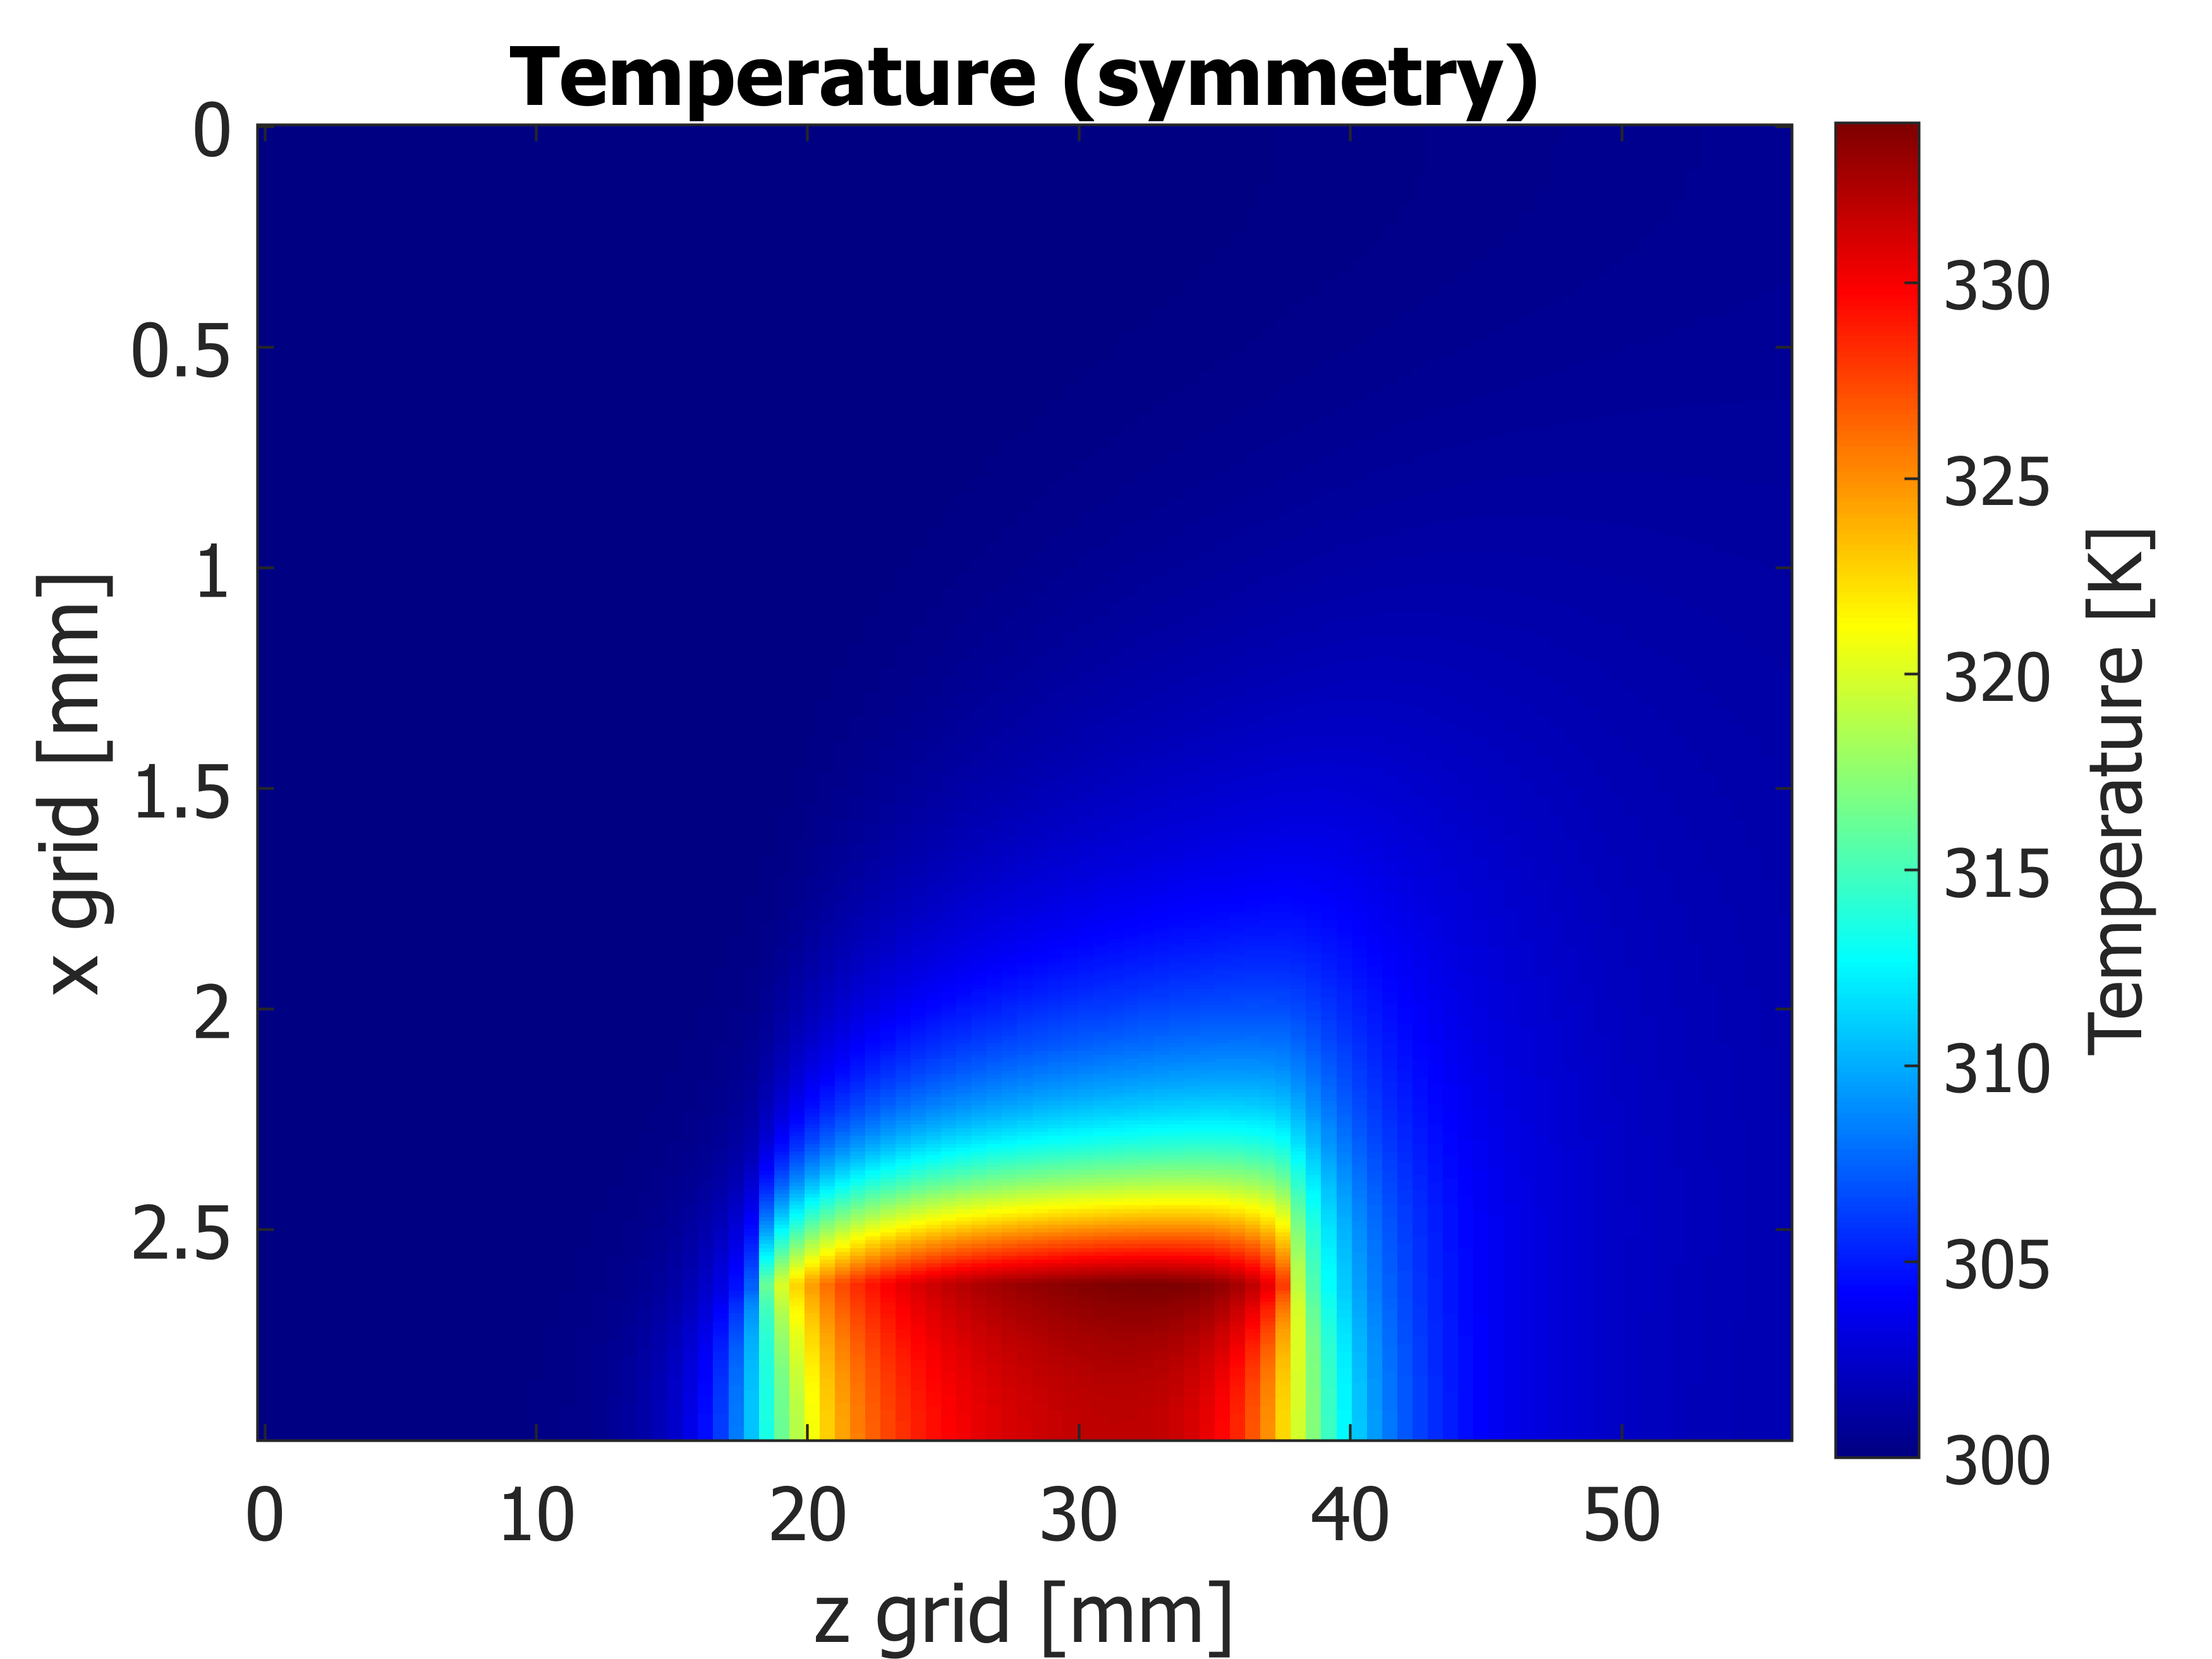

In [12]:

figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm, x_grid_total*1000, T_2d_symmetry');
xlabel('z grid [mm]')
ylabel('x grid [mm]')
title('Temperature (symmetry)')
c = colorbar;
ylabel(c, 'Temperature [K]','FontSize',fontsize,'fontname','times')
set(gca,'FontSize',fontsize,'fontname','times')
colormap('jet')

## centerline profile


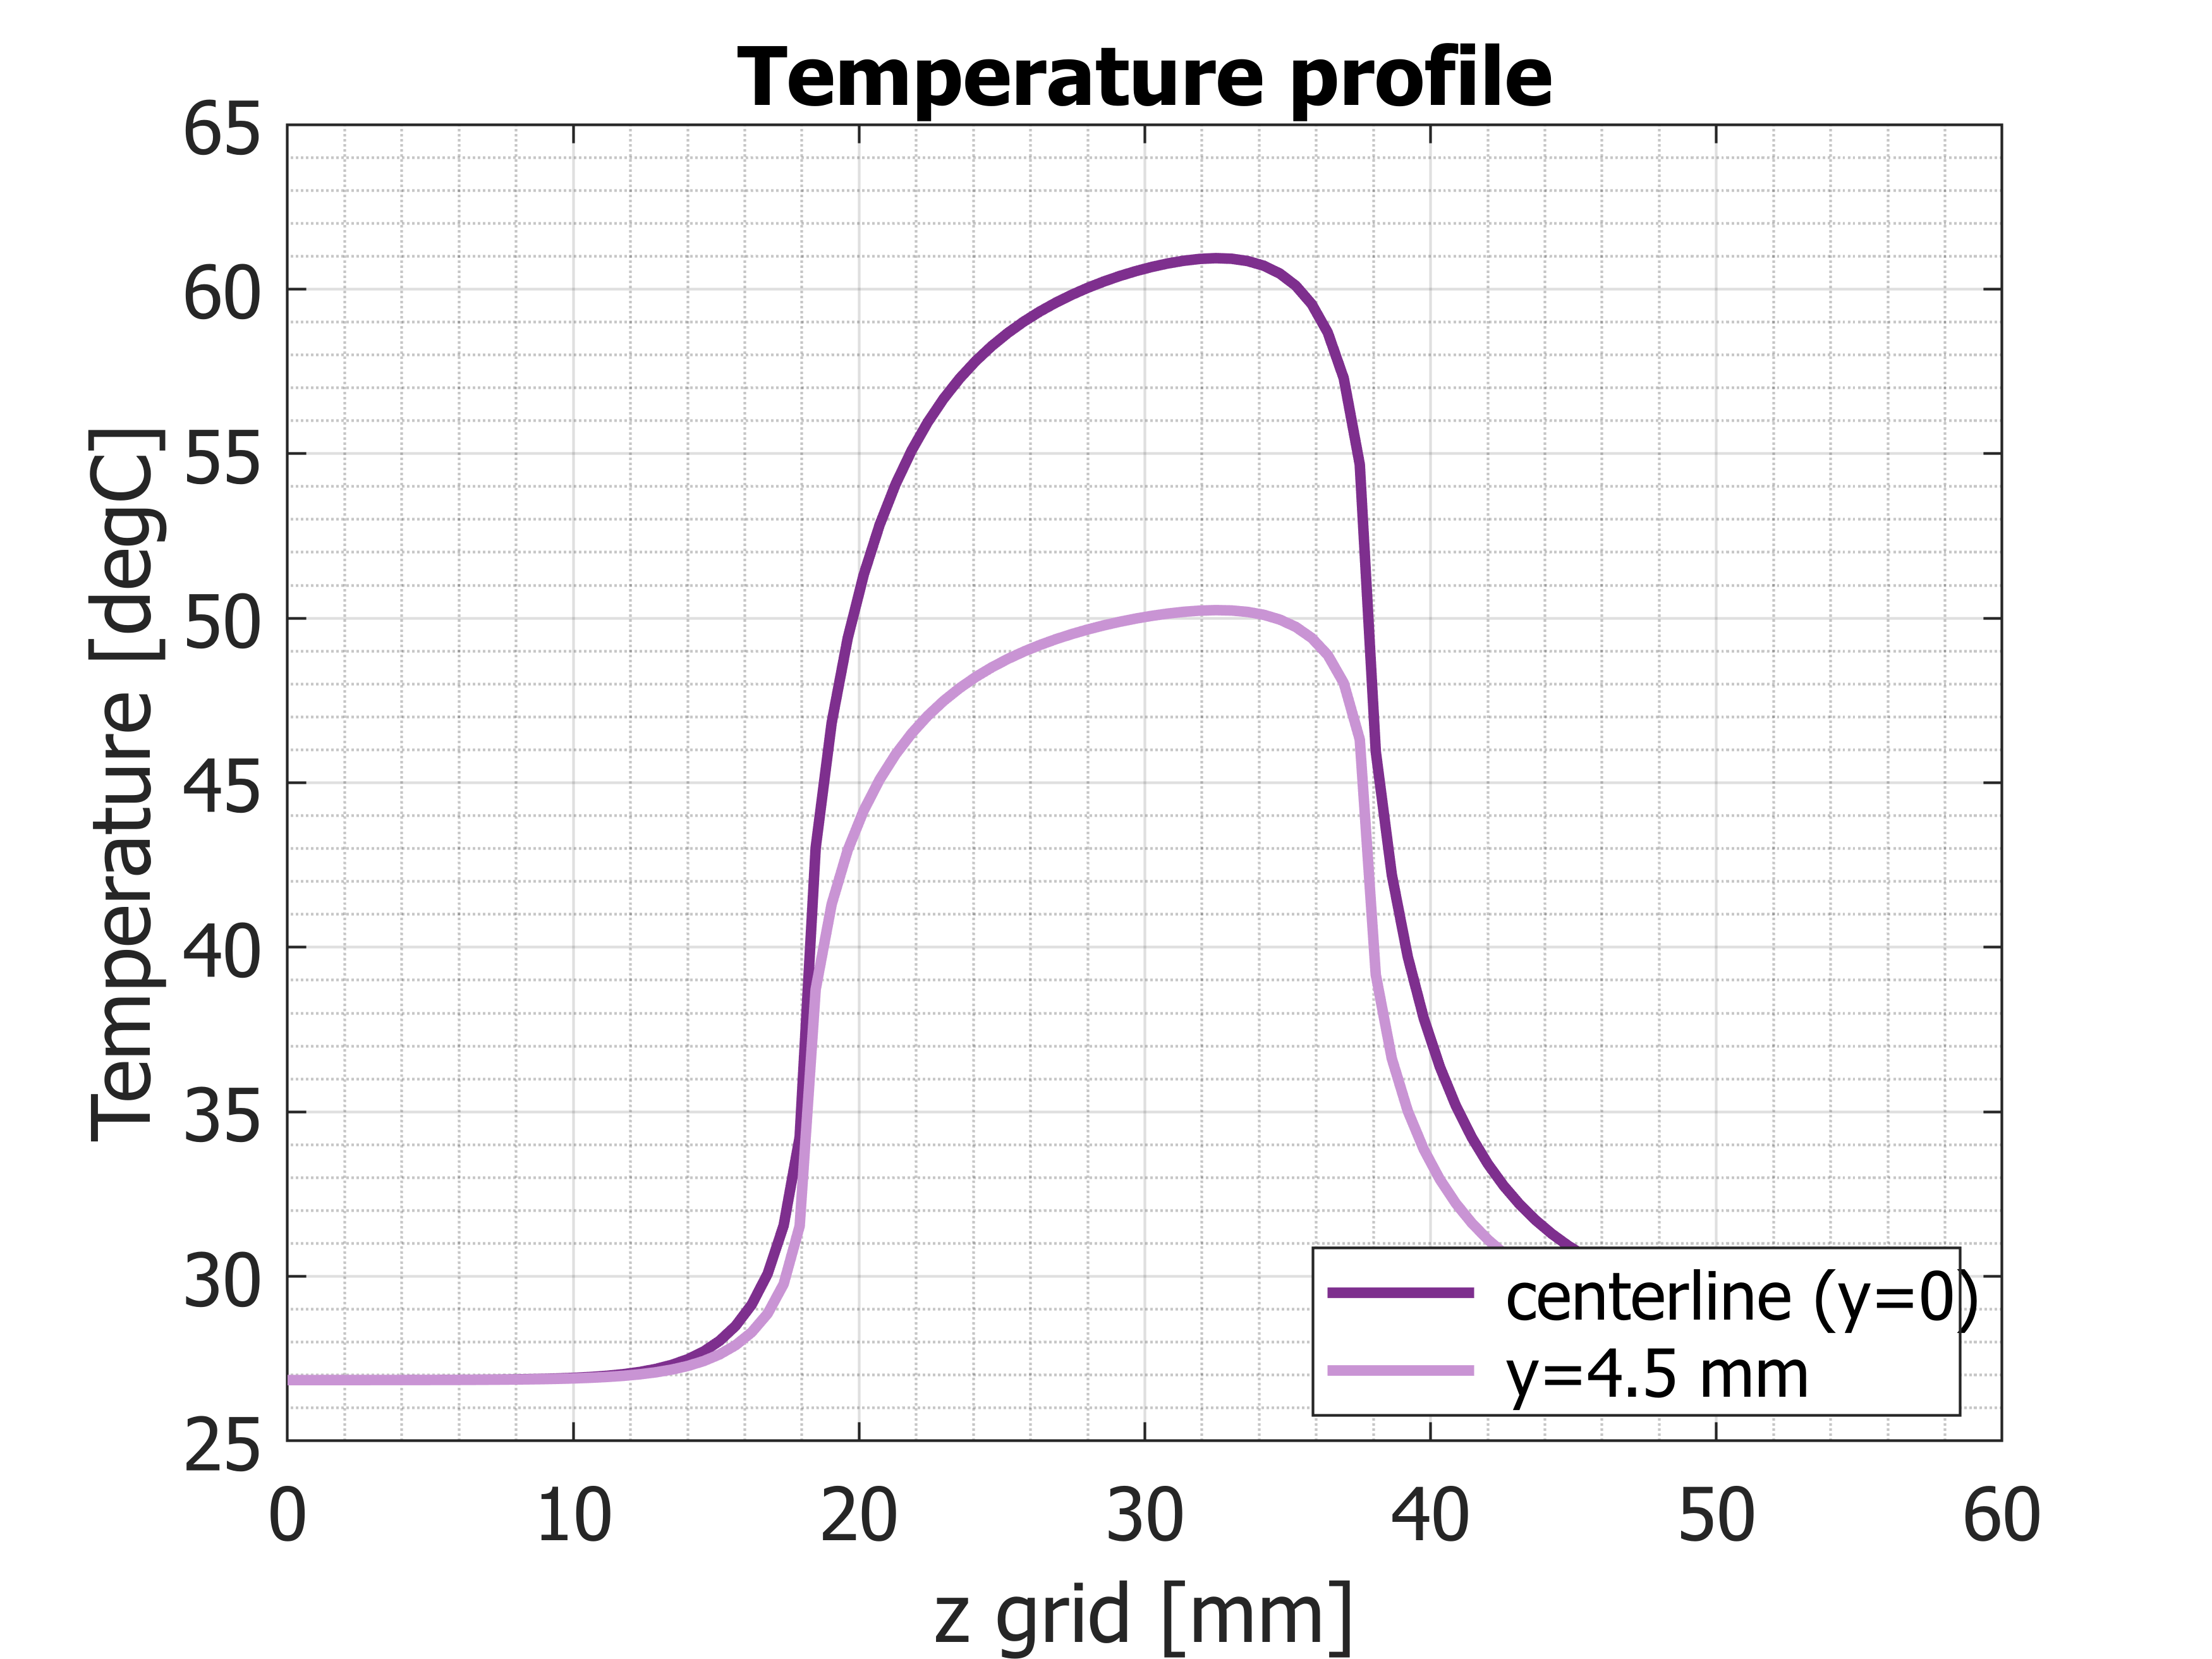

In [13]:
figure;
set(gcf, 'WindowState', 'maximized');
% subplot(1,2,1)
plot(z_grid_mm, T_wall_1 - 273.15,'Linewidth',2,'Displayname',' centerline (y=0)','color','#7E2F8E') % purple
hold on
plot(z_grid_mm, T_wall_2 - 273.15, 'LineWidth', 2, ...
    'DisplayName', [' y=', num2str(y_grid_mm(index_plane2)), ' mm'], ...
    'Color', '#c994d4'); % purple
xlabel('z grid [mm]')
ylabel('Temperature [degC]')
legend('show','location','southeast')
title(['Temperature profile'])
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor


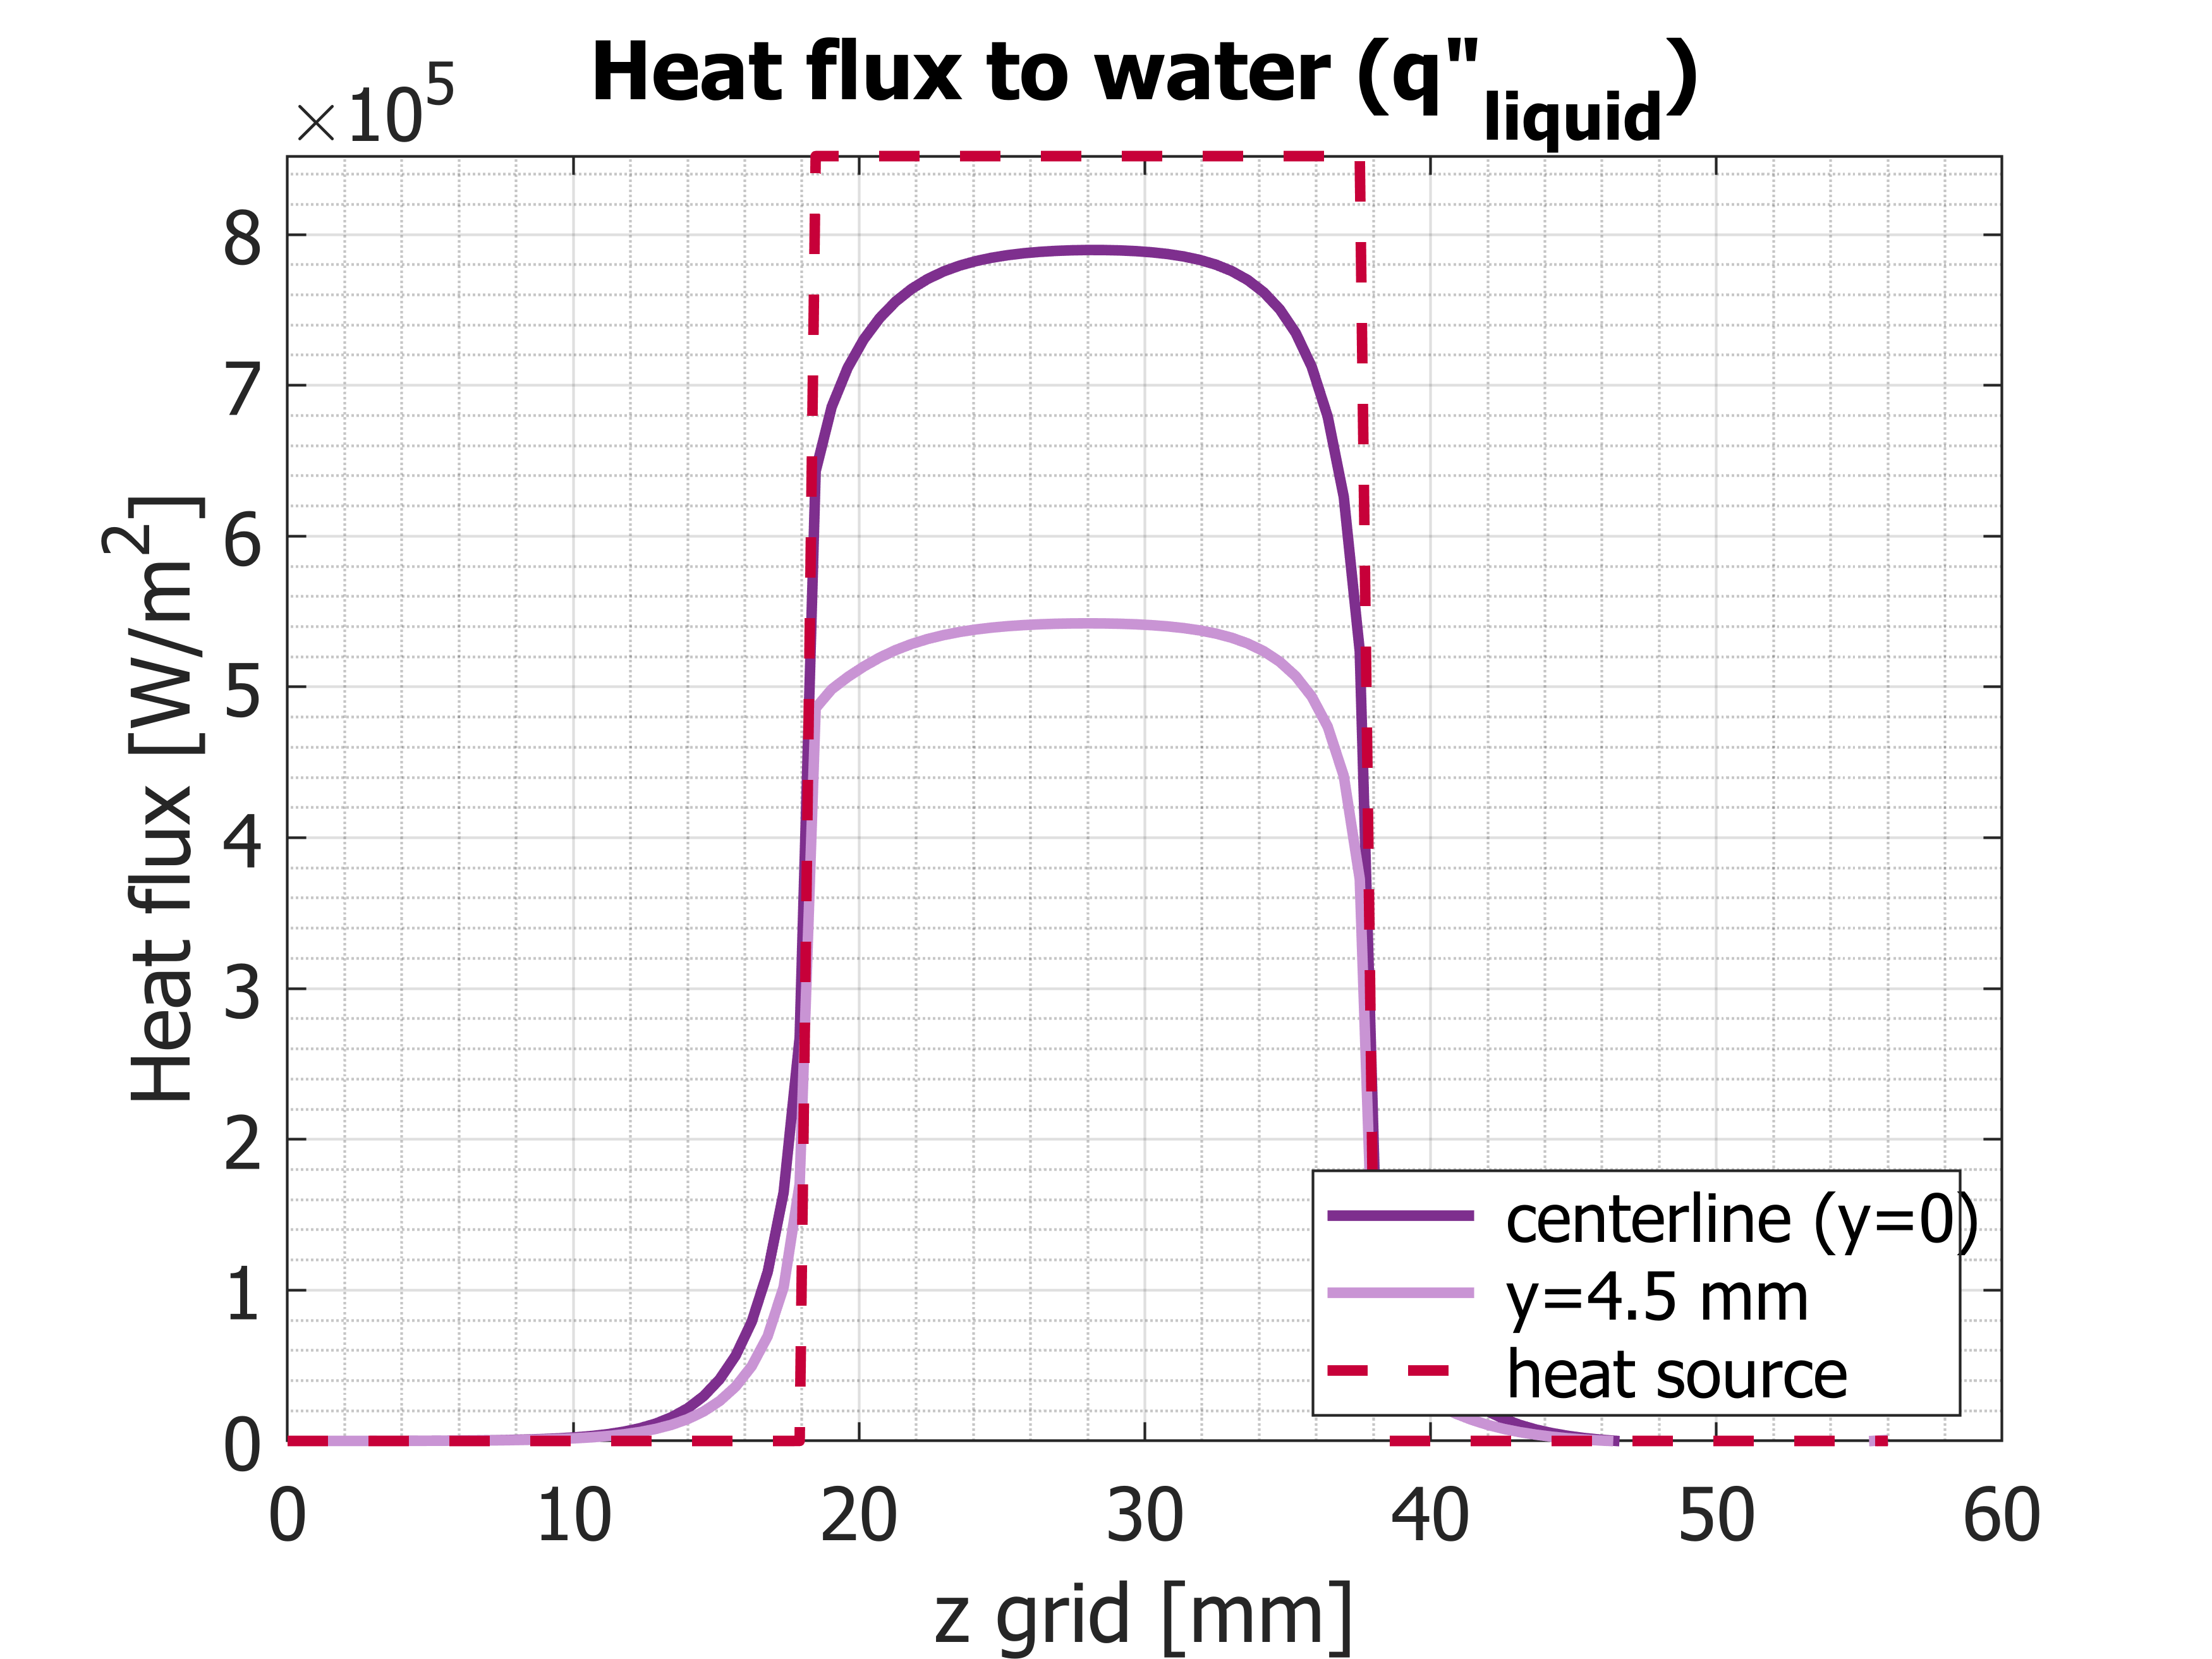

In [14]:

figure;
set(gcf, 'WindowState', 'maximized');
plot(z_grid_mm, -q_liquid_1,'Linewidth',2,'Displayname',' centerline (y=0)','color','#7E2F8E') % purple
hold on
plot(z_grid_mm, -q_liquid_2, 'LineWidth', 2, ...
    'DisplayName', [' y=', num2str(y_grid_mm(index_plane2)), ' mm'], ...
    'Color', '#c994d4'); % purple
hold on
plot(z_grid_mm, q_sum,'--','Linewidth',2,'displayname',' heat source','color','#C70039')
xlabel('z grid [mm]')
ylabel('Heat flux [W/m^2]')
xlim([0 60])
ylim([0 inf])
hold on
legend('show','location','southeast')
title(['Heat flux to water (q"_{liquid})'])
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor